In [1]:
%load_ext Cython

In [2]:
%%cython
# distutils: language = c++
from __future__ import print_function
import numpy as np
cimport numpy as np
cimport cython
from libcpp.algorithm cimport sort,unique
from libcpp.vector cimport vector
from libc.math cimport ceil
from libc.math cimport pow as pow_C 

from tqdm import tqdm
from joblib import Parallel,delayed
#import multiprocessing


@cython.boundscheck(False) 
@cython.wraparound(False)  
cdef double my_abs(double x) nogil:
    if x > 0:
        return x
    else:
        return -x
    
# @cython.boundscheck(False) 
# @cython.wraparound(False)  
# cdef double[:] _sort_cpp(double[:] a):
#     # a must be c continuous (enforced with [::1])
#     sort(&a[0], (&a[0]) + a.shape[0])
#     return a 

@cython.boundscheck(False) 
@cython.wraparound(False)    
cdef double _Wp(vector[double] P, vector[double] Q, int p = 2) nogil:
    cdef int N1_int = P.size()
    cdef int N2_int = Q.size()
    #cdef int N1_int = P.shape[0]
    #cdef int N2_int = Q.shape[0]
    cdef double N1 = N1_int
    cdef double N2 = N2_int 
    cdef vector[double] U1
    
    # cdef double[:] P_sorted = _sort_cpp(P)
    # cdef double[:] Q_sorted = _sort_cpp(Q)
    sort(P.begin(),P.end())
    sort(Q.begin(),Q.end())
    
    # cdef vector[double] P_sorted
    # P_sorted.reserve(N1_int)
    # for j in range(N1_int):
    #     P_sorted.push_back(P[j])
    # 
    # cdef vector[double] Q_sorted
    # Q_sorted.reserve(N2_int)
    # for j in range(N2_int):
    #     Q_sorted.push_back(Q[j])
    # 
    # sort(P_sorted.begin(),P_sorted.end())
    # sort(Q_sorted.begin(),Q_sorted.end())
    
    U1.reserve(N1_int+1)
    cdef double _i = 1
    U1.push_back(0)
    cdef int j
    cdef int i
    for j in range(N1_int):
        U1.push_back(_i/N1)
        _i += 1.
        
    _i = 1    
    
    cdef vector[double] U2
    U2.reserve(N2_int)
    for j in range(N2_int):
        U2.push_back(_i/N2)
        _i += 1
    cdef vector[double] U
    # concatenate & remove duplicates & sort
    U.reserve(U1.size()+U2.size())
    U.insert( U.end(), U1.begin(), U1.end() )
    U.insert( U.end(), U2.begin(), U2.end() )
    sort(U.begin(),U.end())
    U.erase(unique(U.begin(),U.end()),U.end())
    
    
    cdef int N_max = U.size() - 1
    
    #cdef double N_max_double = N_max 
    cdef double dist = 0
    # cdef int index1
    # cdef int index2
    # print(U)
    # print(P)
    # print(Q)
    for i in range(N_max):
        # index1 = int(ceil(U[i]*(N1-1)))
        # index2 = int(ceil(U[i]*(N2-1)))
        dist += pow_C(my_abs(P[int(ceil(U[i]*(N1-1)))] - Q[int(ceil(U[i]*(N2-1)))]),p)*(U[i+1] - U[i])
        #Wp_dist += P[int(ceil(U[i]*(N1-1)))] - Q[int(ceil(U[i]*(N2-1)))]
        #dist += 1
        #print(int(ceil(U[i]*(N1-1))))
    return pow_C(dist,1./float(p)) 
cdef inline double _calculate_Wp_difference(int[:] A,
                                     int split_direction,
                                     double split_value,
                                     double[:,:] X,
                                     double[:] Y,
                                     int p = 2) nogil:
    cdef int A_size = A.shape[0]
    cdef vector[double] Y_left
    cdef vector[double] Y_right
    cdef vector[double] Y_both
    Y_left.reserve(A_size)
    Y_right.reserve(A_size)
    Y_both.reserve(A_size)
    
    cdef int i
    cdef int _i
    for i in range(A_size):
        _i = A[i]
        Y_both.push_back(Y[_i])
        if X[_i,split_direction] < split_value:
            Y_left.push_back(Y[_i])
            #Y_left.push_back(1)
        else:
            Y_right.push_back(Y[_i])
            #Y_right.push_back(1)
    cdef double result = 0
    
    # cdef double mean_Y = my_mean(Y_both)
    # cdef double mean_L = my_mean(Y_left)
    # cdef double mean_R = my_mean(Y_right)
    # 
    # # cdef double result_L = 0
    # # cdef double result_R = 0
    # for i in range(A_size):
    #     result += (Y[i]-mean_Y)*(Y[i]-mean_Y)
    #     #result += my_w1(Y_both[i],Y_both)
    # for i in range(Y_left.size()):
    #     result -= (Y_left[i]-mean_L)*(Y_left[i]-mean_L)
    #     #result -= my_w1(Y_left[i],Y_left)
    # for i in range(Y_right.size()):
    #     result -= (Y_right[i]-mean_R)*(Y_right[i]-mean_R)
    #     #result -= my_w1(Y_right[i],Y_right)
   
    
    
    #return _Wp(P = Y_left,Q = Y_right, p = p)+_Wp(P = Y_both,Q = Y_right, p = p)+_Wp(P = Y_both,Q = Y_left, p = p)
    #return _Wp(P = Y_left,Q = Y_right, p = p)+float(Y_right.size())/float(A_size)*_Wp(P = Y_both,Q = Y_right, p = p)+float(Y_left.size())/float(A_size)*_Wp(P = Y_both,Q = Y_left, p = p)
    
    # a good choice
    return float(Y_right.size())*_Wp(P = Y_both,Q = Y_right, p = p)+float(Y_left.size())*_Wp(P = Y_both,Q = Y_left, p = p)


@cython.boundscheck(False) 
@cython.wraparound(False)    
def getALAR(int[:] A,
            int split_direction,
            double split_value,
            double[:,:] X):
    
    cdef vector[int] _AL
    cdef vector[int] _AR
    cdef int A_size = A.shape[0]
    _AL.reserve(A_size)
    _AR.reserve(A_size)
    for i in range(A_size):
        if X[A[i],split_direction] < split_value:
            _AL.push_back(A[i])
        else:
            _AR.push_back(A[i])
            
    #cdef int[:] AL = _AL.data()
    #cdef int[:] AR = _AR.data()
    
    # cdef int *AL = &_AL[0]    
    # cdef int[::1] AL_view = <int[:_AL.size()]>AL    # cast to typed memory view
    
    # cdef int *AR = &_AL[0]    
    # cdef int[::1] AR_view = <int[:_AL.size()]>AR
    # # 
    return np.asarray(_AL,dtype=np.intc),np.asarray(_AR,dtype=np.intc)
    #return 0 




# Wp_split
@cython.boundscheck(False) 
@cython.wraparound(False)    
def Wp_split(int[:] A,
             int[:] Mtry,
             double[:,:] X,
             double[:] Y,
             int p = 2):
    
    #cdef int min_sample_each_node = 1  
    cdef int A_size = A.shape[0]  
    cdef int mtry = Mtry.shape[0]
    
    cdef int _size_list = (A_size-1)*mtry
    
    cdef vector[int] direction_list 
    direction_list.reserve(_size_list)
    cdef vector[double] value_list 
    value_list.reserve(_size_list)
    
    cdef int split_direction
    
    cdef vector[double] Xtry 
    Xtry.reserve(A_size)
    
    cdef int i
    cdef int j
    
    for i in range(mtry):
        split_direction = Mtry[i]
        #Xtry = np.sort(list(set(X[A,:][:,split_direction])))
        for j in range(A_size):
            Xtry.push_back(X[A[j],split_direction])
        sort(Xtry.begin(),Xtry.end())
        #print("X_before",Xtry.size())
        Xtry.erase(unique(Xtry.begin(),Xtry.end()),Xtry.end())
        #print("X_after",Xtry.size())
        #Xtry = np.sort(list(set(X[A,split_direction])))
        #candidate_current_direction = (Xtry[min_sample_each_node:] + Xtry[:-min_sample_each_node])*.5
        for j in range(Xtry.size() - 1):
            direction_list.push_back(split_direction)
            value_list.push_back((Xtry[j+1]+Xtry[j])*0.5)
        Xtry.clear()
        #theta_list += [[split_direction,candidate_current_direction[i]] for i in range(len(Xtry) -min_sample_each_node)]
    
    #print("values:",value_list)
    cdef vector[double] Wp_list
    Wp_list.reserve(direction_list.size())
    for i in range(direction_list.size()):
        Wp_list.push_back(_calculate_Wp_difference(A = A,
                                                   Mtry = Mtry,
                                                   split_direction = direction_list[i],
                                                   split_value = value_list[i],
                                                   X = X,
                                                   Y = Y,
                                                   p = p))
        
    #cdef int argMax = max_element(Wp_list.begin(), Wp_list.end())-Wp_list.begin()
    # cdef double *Wp_array = &Wp_list[0]    
    # cdef double[::1] Wp_view = <double[:Wp_list.size()]>Wp_array
    #Wp_np = np.asarray(Wp_view)
    
    cdef int index_max = my_argmax(Wp_list) 

    return direction_list[index_max], value_list[index_max] 

@cython.boundscheck(False) 
@cython.wraparound(False)    
cdef int my_argmax(vector[double] x) nogil:
    cdef int i
    cdef int _i = 0
    cdef double _x = x[0]
    for i in range(x.size()):
        if x[i] >= _x:
            _i = i
            _x = x[i]
    return _i

In [3]:
class node:
    def __init__(self, left = None, right = None, parent = None, split = None, neighbours = None, nodes = None):
        self.left = left 
        self.right = right 
        self.parent = parent 
        self.split = split  
        self.neighbours = neighbours 
        
class DecisionTree:
    def __init__(self,
                 mtry = 1,
                 nodesize = 5,
                 subsample = 0.8,
                 bootstrap = True,
                 p = 2,
                 nodes = None):
        #self.nodes = nodes # P 
        # parameters
        self.mtry = mtry
        self.nodesize = nodesize
        self.subsample = subsample 
        self.bootstrap = bootstrap 
        self.p = p 
        self.Y = None
    def fit(self,X,Y):
        self.Y = Y
        N,d = X.shape 
        if self.subsample <= 1:
            subsample_size = int(N*self.subsample)
        elif self.subsample > 1:
            subsample_size = int(self.subsample)
        else:
            subsample_size = 100
            print("Wrong subsample is given, used subsample = 100 as default.")
        S_b = np.random.choice(range(N), subsample_size, replace  = self.bootstrap)
        self.nodes = node(neighbours = S_b)
        P =[self.nodes] 
        while P:
            # A is current node
            A = P[0] 
            if len(A.neighbours) < self.nodesize or len(set(Y[A.neighbours])) == 1:
                del P[0]
            else:
                Mtry = np.random.choice(range(d),self.mtry,replace = False)
                #print(type(np.array(Mtry,dtype = int)[0]))
                theta_star = Wp_split(np.array(A.neighbours,dtype = np.intc),np.array(Mtry,dtype = np.intc),X,Y,self.p)
                A.split = theta_star
                #theta_star_list += [theta_star] 
                AL,AR = getALAR(np.array(A.neighbours,dtype = np.intc),theta_star[0],theta_star[1],X)
                del P[0]
                A.left = node(neighbours = AL, parent  = A)
                A.right = node(neighbours = AR, parent  = A)
                P += [A.left,A.right]
        
    def _predict(self,x):
        current_node = self.nodes
        while current_node.split:
            direction,value = current_node.split
            if x[direction]<value:
                current_node = current_node.left
            else:
                current_node = current_node.right
        return np.mean(self.Y[current_node.neighbours])
    def predict_distribution(self,x):
        current_node = self.nodes
        while current_node.split:
            direction,value = current_node.split
            if x[direction]<value:
                current_node = current_node.left
            else:
                current_node = current_node.right
        N_final = self.Y.shape[0]
        empirical_measure = np.zeros(N_final)
        for i in current_node.neighbours:
            empirical_measure[i] += 1.
        return empirical_measure/float(len(current_node.neighbours))
            
    def predict(self,x):
        return np.apply_along_axis(lambda x : self._predict(x),1,x)
        
class WassersteinRandomForest:
    def __init__(self,
                 mtry = 1,
                 nodesize = 5,
                 subsample = 0.1,
                 bootstrap = False,
                 n_estimators = 10,
                 #n_jobs = 1,
                 p = 2):
        # parameters
        self.mtry = mtry
        self.nodesize = nodesize
        self.subsample = subsample 
        self.bootstrap = bootstrap 
        self.n_estimators = n_estimators
        #self.n_jobs = n_jobs
        self.n_jobs = 1 
        self.p = p
        #self.ListLearners = None 
        self.ListLearners = []
        self.Y = None
        
    def reset_random_state(self):
        f = open("/dev/random","rb")
        rnd_str = f.read(4)
        rnd_int = int.from_bytes(rnd_str, byteorder = 'big')
        np.random.seed(rnd_int)

    def _fit(self,X,Y):
        # if self.n_jobs > 1:
        #     self.reset_random_state()
        BaseLearner = DecisionTree(mtry = self.mtry,
                                   nodesize = self.nodesize,
                                   subsample = self.subsample,
                                   bootstrap = self.bootstrap,
                                   p = self.p)
        BaseLearner.fit(X,Y)
        return BaseLearner

    def fit(self,X,Y):
        self.Y = Y
        if self.n_jobs ==1:
            #self.ListLearners = []
            for i in tqdm(range(self.n_estimators)):
                self.ListLearners += [self._fit(X,Y)]
        else:
            #ListLearners = Parallel(n_jobs=self.n_jobs)(delayed(self._fit)(X,Y) for i in tqdm(range(self.n_estimators)))

            results =\
            Parallel(n_jobs=self.n_jobs)(delayed(self._fit) (X=X,Y=Y) for i in tqdm(range(self.n_estimators)))

            self.ListLearners = results 
    # def fit(self,X,Y):
    #     self.Y = Y
    #     for i in tqdm(range(self.n_estimators)):
    #         #BaseLearner = DecisionTree(mtry = self.mtry,
    #         #                           nodesize = self.nodesize,
    #         #                           subsample = self.subsample,
    #         #                           bootstrap = self.bootstrap,
    #         #                           p = self.p)
    #         #BaseLearner.fit(X,Y)
    #         self.ListLearners += [self._fit(X,Y)]
    def predict(self,x):
        prediction = np.zeros(x.shape[0])
        for i in range(self.n_estimators):
            prediction += self.ListLearners[i].predict(x)
        prediction /= float(self.n_estimators)
        return prediction
    def predict_distribution(self,x):
        empirical_measure = np.zeros(len(self.Y))
        for i in range(self.n_estimators):
            current_empirical_measure= self.ListLearners[i].predict_distribution(x)
            empirical_measure += current_empirical_measure
        return self.Y,empirical_measure/float(self.n_estimators)

# Generating synthetic dataset 

In [4]:
import matplotlib.pyplot as plt
import numpy as np

N_total = 700
N_train = 500
X = np.random.uniform(0,1,(N_total,4))
#X = np.random.normal(0,1,(N_total,10))
def obj_func(x):
    """
    conditional expectation
    """
    # x0_tilde = 2.*(x[0] - 0.5)
    # x1_tilde = 2.*(x[1] - 0.5)
    # return x0_tilde**2 + x[3]*x[4]
    # c = 0
    # for i in range(3):
    #     #c *= x[i]*np.sin(i)
    #     c += x[i]*np.sin(i)
    return 10*x[1] + x[2]
def obj_func2(x):
    """
    conditional variance
    """
    #return np.abs(np.sin(x[0])+x[1])*1.5
    #return np.abs(x[0]+x[1])*1.5
    return np.max([x[3]*9., 0.2])
    #return 0.5

# def obj_func3(x):
#     """
#     conditional expectation
#     """
#     #return x[1]+2.*x[2] +2. +np.sin(2.*x[0])
#     c = 0
#     for i in range(4,7):
#         #c *= x[i]*np.sin(i)
#         c += x[i]*np.cos(i)
#     #return x[1] + x[2]
#     return c


#Y = np.random.normal(0,1.,N_total) + np.apply_along_axis(obj_func,1,X)
Y = np.zeros(N_total)
for i in range(N_total):
    if np.random.rand()<0.5:
        Y[i] = np.random.normal(obj_func(X[i]),np.sqrt(obj_func2(X[i])),1)
    else:
        #Y[i] = np.random.normal(obj_func(X[i]),np.sqrt(obj_func2(X[i])),1)
        # Y[i] = np.random.normal(-0.05*obj_func2(X[i]),1,1)
        #Y[i] = np.random.normal(-1.5*obj_func2(X[i]),1,1)
        #Y[i] = np.random.normal(obj_func3(X[i]),1,1)

        #Y[i] = np.random.normal(-1,1,1)
        Y[i] = np.random.normal(obj_func(X[i]),np.sqrt(obj_func2(X[i])),1)

## Training

In [5]:
reg = WassersteinRandomForest(nodesize = 2,
                             bootstrap = False,
                             subsample = 200,
                             n_estimators = 500,
                             mtry = 4,
                             #n_jobs = 1,
                             p = 2)
#reg = DecisionTree()
reg.fit(X[:N_train],Y[:N_train])

100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


## Conditional expectation estimation

In [6]:
from sklearn.metrics import mean_squared_error, r2_score
predlist = reg.predict(X[N_train:])
print("Wasserstein RF")
print("R2:",r2_score(np.apply_along_axis(obj_func,1,X[N_train:]),predlist))
print("MSE:",
        np.sqrt(mean_squared_error(np.apply_along_axis(obj_func,1,X[N_train:]),predlist))
     )
#print("Memory usage:", process.memory_info().rss/1024/1024,"MB")

Wasserstein RF
R2: 0.9533415308974603
MSE: 0.6281719538242146


In [7]:
# compare with classical Random Forests
from sklearn.ensemble import RandomForestRegressor
#from skgarden import MondrianForestRegressor

reg2 = RandomForestRegressor(n_estimators = 500,
                             min_samples_split = 5,
                             bootstrap = 1 
                             #max_features = 1 
                            )
# reg2 = MondrianForestRegressor(n_estimators = 500,
#                             min_samples_split = 5,
#                             bootstrap = False)
reg2.fit(X[:N_train],Y[:N_train])

print("Classical RF")
print("R2:",r2_score(np.apply_along_axis(obj_func,1,X[N_train:]),reg2.predict(X[N_train:])))
print("MSE:",
        np.sqrt(mean_squared_error(np.apply_along_axis(obj_func,1,X[N_train:]),reg2.predict(X[N_train:])))
     )

Classical RF
R2: 0.941509909097895
MSE: 0.7033223977090548


## Conditional distribution estimation

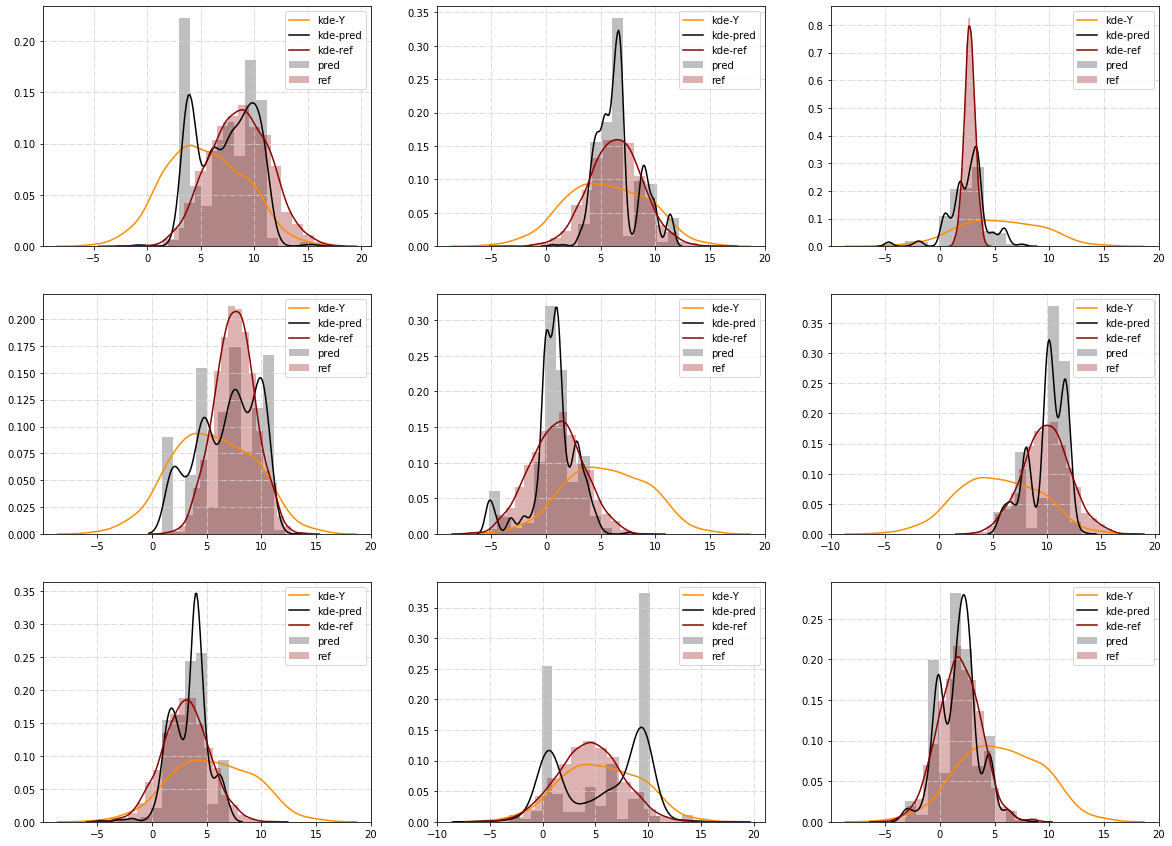

In [8]:
from seaborn import kdeplot

plt.figure(figsize = (20,15))
for IndexPlot in range(9):
    plt.subplot(int("33"+str(IndexPlot+1)))
    TestIndex = np.random.choice(range(N_total-N_train),1)[0]
    #TestIndex = np.random.choice(range(N_train),1)[0]
    #plt.hist(Y, density = True, color = "orange",alpha = 0.3, bins = 20, label="Y")
    kdeplot(Y, label="kde-Y", color = "darkorange")
    Y,W = reg.predict_distribution(X[-TestIndex])
    kdeplot(np.random.choice(a = Y,p = W,size = 1000), label="kde-pred", color = "black")
    plt.hist(Y,weights=W, bins = 20, color = "grey", density = True,alpha = 0.5, label="pred")
    #ref_sample = np.random.normal(obj_func(X[-TestIndex]),np.sqrt(obj_func2(X[-TestIndex])),2000)
    ref_sample = np.zeros(2000)
    for i in range(2000):
        if np.random.rand()<0.5:
            ref_sample[i] = np.random.normal(obj_func(X[-TestIndex]),np.sqrt(obj_func2(X[-TestIndex])),1)
        else:
            #ref_sample[i] = np.random.normal(-1.5*obj_func2(X[TestIndex]),1,1)
            # ref_sample[i] = np.random.normal(obj_func3(X[TestIndex]),1,1)

            #ref_sample[i] = np.random.normal(-1,1,1)
            ref_sample[i] = np.random.normal(obj_func(X[-TestIndex]),np.sqrt(obj_func2(X[-TestIndex])),1)

    plt.hist(ref_sample,
             density = True, color = "darkred",alpha = 0.3, bins = 20, label="ref")
    kdeplot(ref_sample, label = "kde-ref", color = "darkred")
    plt.grid(linestyle = "-.",color="lightgrey")
    plt.legend()
plt.show()


# Calculate average Wp distance with 100 points in test dataset

In [9]:
from ot import wasserstein_1d
predlist = []
predlistY = []
ideallist = []
for i in range(100):
    Y_c,W_c = reg.predict_distribution(X[N_train+i])
    predlist +=[wasserstein_1d(p = 2,x_a = np.random.choice(Y_c,p=W_c,size = N_train),x_b =np.random.normal(obj_func(X[N_train+i]),np.sqrt(obj_func2(X[N_train+i])),100000))]
    predlistY +=[wasserstein_1d(p = 2,x_a = Y[:N_train],x_b =np.random.normal(obj_func(X[N_train+i]),np.sqrt(obj_func2(X[N_train+i])),100000))]
    ideallist += [wasserstein_1d(p = 2,x_a =np.random.normal(obj_func(X[N_train+i]),np.sqrt(obj_func2(X[N_train+i])),N_train),
                                   x_b = np.random.normal(obj_func(X[N_train+i]),np.sqrt(obj_func2(X[N_train+i])),10000))] 

print("average Wp distance:", np.mean(predlist))
print("average Wp distance with Y (i.e., no estimation is made):", np.mean(predlistY))
print("ideal average Wp distance", np.mean(ideallist))

average Wp distance: 1.0645425246279427
average Wp distance with Y (i.e., no estimation is made): 3.16999179158797
ideal average Wp distance 0.15835057484965903
